## Ré-échantillonage

In [71]:
import os
import argparse
import torch as th
import torch.nn.functional as F
import time
import conf_mgt
from utils import yamlread
from guided_diffusion import dist_util
from tqdm import tqdm
# Workaround
try:
    import ctypes
    libgcc_s = ctypes.CDLL('libgcc_s.so.1')
except:
    pass


from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    select_args,
)  # noqa: E402

from guided_diffusion.script_util import (
    sr_model_and_diffusion_defaults,
    sr_create_model_and_diffusion,
)
def toU8(sample):
    if sample is None:
        return sample

    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.detach().cpu().numpy()
    return sample

import torch
import torchvision
import torchvision.transforms as T

from guided_diffusion.scheduler import get_schedule_jump
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()

In [2]:
intermediate_steps = False #return intermediate results (usefull to create gifs, but will use lot of memory - around 3GB for one 256x256 image)
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread('confs/my_conf-2-attention.yml'))
print(conf.inpa_inj_sched_prev) #Are you about to use RePainting ?print(conf.diffusion_steps) #may not be the good one
conf.intermediate_steps = intermediate_steps
print(conf.intermediate_steps)


True
False


In [3]:
print("Start", conf['name'])

device = dist_util.dev(conf.get('device'))


model, diffusion = create_model_and_diffusion(
    **select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
)


Start my_conf


In [4]:
model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)
model.to(device)
if conf.use_fp16:
    model.convert_to_fp16()
model.eval()


import numpy as np
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Nombre de paramètres : ', params)

Nombre de paramètres :  552814086


In [ ]:
# https://colab.research.google.com/drive/12a_Wrfi2_gwwAuN3VvMTwVMz9TfqctNj#scrollTo=7zAqFEykBHDL TO DO

In [5]:

cond_fn = None

def model_fn(x, t, y=None, gt=None, **kwargs):
    assert y is not None
    return model(x, t, y if conf.class_cond else None, gt=gt)

In [6]:
dset = 'eval'

eval_name = conf.get_default_eval_name()

IMAGE_SIZE = 256
GT_PATH = './data/datasets/gts/dogs'
MASK_PATH = './data/datasets/gt_keep_masks/genhalf'
dataconfig = {'mask_loader': True,
 'gt_path': GT_PATH,
 'mask_path': MASK_PATH,
 'image_size': IMAGE_SIZE,
 'class_cond': False,
 'deterministic': True, # Pas de shuffle dans le dataloader
 'random_crop': False, # Crop (au lieu de redimensionner l'image). Non Implémenté.
 'random_flip': False,
 'return_dict': True,
 'drop_last': False,
 'batch_size': 1,
 'return_dataloader': True,
 'offset': 0,
 'max_len': None,
 'paths': {'srs': './log/face_example/inpainted',
  'lrs': './log/face_example/gt_masked',
  'gts': './log/face_example/gt',
  'gt_keep_masks': './log/face_example/gt_keep_mask'}
             }

conf['data']['eval'][eval_name] = dataconfig

return_all = True
conf.intermediate_steps = False
path_save_checkpoint = './data/datasets/gts/dogs/checkpoints/'
path_save_finals = './inpainted/dogs/finals/'
path_save_resamples = './inpainted/dogs/from_checkpoint/'
format_save = '.png'
transform = T.ToPILImage()
def tou8batch(result,return_all=False):
    if return_all:
        finals = result[1]['sample']
    else:
        finals = result
    finals = ((finals + 1) * 127.5).clamp(0, 255).to(th.uint8)
    finals = finals.contiguous()
    return(finals)

In [7]:


if conf.schedule_jump_params:
            times = get_schedule_jump(**conf.schedule_jump_params)

            time_pairs = list(zip(times[:-1], times[1:]))
            time_pairs = np.array(time_pairs)
            allowed = [0 if i[0]<i[1] else 1 for i in time_pairs]
            
to_save = (190*np.array(range(23))+200) #Indexes of steps we want to save. It is every 10 diffusion reverse, for conf jump : 250,10,10.

In [8]:
#Initialize folder structure and copy generated sample

import blobfile as bf
import shutil


images = np.array(sorted(bf.listdir(path_save_finals)))
samples_unique = np.unique([i[:6] for i in images])
for folder_name in samples_unique:
    path = path_save_resamples+folder_name
    if not os.path.exists(path):
        os.mkdir(path)
    samples = np.array(images)[[folder_name in i for i in images]]
    samples = [i[:-4] for i in samples]
    for i in samples:
        path_i = path+'/'+i
        path_img_i = path_save_finals+i+format_save
        if not os.path.exists(path_i):
            os.mkdir(path_i)
            shutil.copy(path_img_i, path_i)


In [9]:
input_b = [10,11,13,14,16,17]
mid_b = [0]
output_b = [0,1,2,3,4,5,6,7,8]
blocks = []
for i in input_b:
    blocks.append(model.input_blocks[i][1])
for i in mid_b:
    blocks.append(model.middle_block[1])
for i in output_b:
    blocks.append(model.output_blocks[i][1])
    
def extract_important_patchs(att):
    column_sum = torch.stack([torch.sum(att[:,j]) for j in range(len(att))]) #sum on column is how much a patch is important
    to_keep = (column_sum>torch.quantile(column_sum.type(torch.float32),0.75)).int()
    most_importants = torch.nonzero(to_keep).squeeze(dim=1)
    return(most_importants,column_sum)

def visualize_att(img,patchs,patch_size):
    channels,img_size,_ = img.shape
    l = int(img_size/patch_size) #num patch per line
    num_patch = int(l**2)
    s = th.ones(channels,img_size,img_size)
    im_copy = th.clone(img)


    for i in range(num_patch):
        x1 = patch_size*(i%l)
        y1 = x1 + patch_size
        x2 = patch_size*(i//l)
        y2 = x2+patch_size

        if i in patchs: #if high att
            r,g,b = im_copy[:,x2:y2,x1:y1].unbind(dim=0)
            patch = th.stack([(210*th.ones(patch_size,patch_size)),0.75*g,0.75*b]) #torch.stack([((r+g+b)/3),(g/3),(b/3)])
            #print(patch == img[x2:y2,x1:y1,:])
            s[:,x2:y2,x1:y1] = patch
        else:
            s[:,x2:y2,x1:y1] = im_copy[:,x2:y2,x1:y1]

    return(s.type(th.uint8))

def compute_mask_resized(mask,size): #input : 1,w,h mask
    mask_ds = torchvision.transforms.Resize((size,size))(mask)[0] #return tensor with channel dim
    mask_ds = 1 - mask_ds #pas efficace car il faut convertir en 1 channel avant de resize dans l'idéal
    return(mask_ds) #downsized mask

def compute_att_mask(most_importants,size):
    att_mask = torch.zeros(size**2)
    att_mask[most_importants] = 1
    att_mask = att_mask.reshape((size,size))
    return(att_mask)
    #transforms.ToPILImage()(att_mask) #if uncomment, might be one channel missing

def compute_dist_to_mask(attention,mask_ds):
    att_state_coordinates = torch.argwhere(attention).to(device)
    mask_coordinates = torch.argwhere(mask_ds).to(device)
    values , _ = torch.cdist(x1 = att_state_coordinates.float(),x2 = mask_coordinates.float()).min(dim=1)
    assert values.max()<17
    return(values)

def gen_border(size):
    t = th.zeros((size,size))
    t[:,int(size/2)] = 1
    return(t)

In [10]:
from natsort import os_sorted
import torchvision

dl = conf.get_dataloader(dset=dset, dsName=eval_name)

In [11]:
#for att show progress is False
# VERIFIER QUE LES BLOCS S'UPDATENT AVEC LE MODELE
conf.show_progress = False
show_progress = conf.show_progress

tmp = [[] for i in range(len(blocks))]
tmp_2 = [[] for i in range(len(blocks))] #Is needed : else merrory glitch will merge mo_dist_values_all values with mo_all values... Took time to fix this.
mo_dist_values_all = [tmp for i in range(len(to_save))]
mo_all = [tmp_2 for i in range(len(to_save))]
prop_proche_mask_all = torch.zeros(len(to_save),len(blocks)).to(device)
prop_in_mask_all = torch.zeros(len(to_save),len(blocks)).to(device) #prop of most important patchs in mask (to compare with mask proportion, 0.5 with mid mask)
prop_total_att_in_mask_all = torch.zeros(len(to_save),len(blocks)).to(device) # same but not only most importants : proportion of total attention in mask (colsum)
count = torch.zeros(len(to_save),len(blocks)).to(device) 

k = 0
for batch in tqdm(iter(dl)):
    img = batch['GT'].to(device)
    mask = batch['gt_keep_mask'].to(device)

    name = batch['GT_name'][0][:-4]
    samples = np.array(images)[[name in i for i in images]]
    samples = [i[:-4] for i in samples] #get list of samples generated with this image
    samples = os_sorted(samples)[:1] #taking only 3 samples from each images
    print(samples)
    model_kwargs = {}
    model_kwargs["gt"] = img
    model_kwargs['y'] = '-1' #Utile seulement si conf.cond_y (voir model_fn au dessus). Doit être défini.
    model_kwargs['gt_keep_mask'] = mask
    model_kwargs['stop_to'] = None
    batch_size = model_kwargs['gt'].shape[0]


    for sample_i in samples:
        for L in range(len(to_save)):
            #if k==0:
                k+=1
                start_point = to_save[L]
                path_checkpoint_ij = path_save_checkpoint+sample_i+'_'+str(start_point)+'.pt'
                x_checkpoint = torch.load(path_checkpoint_ij).to(device)

                model_kwargs['starting_point'] = {'x':x_checkpoint,'step':start_point}
                model_kwargs['stop_to'] = start_point+1
                sample_fn = (
                        diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
                )

                result = sample_fn(
                    model_fn,
                    (batch_size, 3, conf.image_size, conf.image_size),
                    clip_denoised=conf.clip_denoised,
                    model_kwargs=model_kwargs,
                    cond_fn=cond_fn,
                    device=device,
                    progress=show_progress,
                    return_all=return_all,
                    conf=conf
                )

                mask_onechan = mask[:,0,:,:] #1,h,w mask
                for i in range(len(blocks)):
                    b = blocks[i]
                    size = b.dim[0]

                    most_importants,total_attentions = extract_important_patchs(b.last_att)

                    mask_ds = compute_mask_resized(mask_onechan,size) #mask downsized
                    mask_border = gen_border(size)
                    attention = compute_att_mask(most_importants,size)
                    values = compute_dist_to_mask(attention,mask_border)

                    mo_dist_values_all[L][i].extend(np.array(values.cpu().detach()))
                    
                    prop_proche_mask = ((values<(0.1*(values.max()-values.min()))).sum())/len(values) #proportion of patchs dans un rayon de 10% la distance maximale
                    prop_in_mask = attention.flatten()[mask_ds.flatten().bool()].sum()/(attention.sum())
                    prop_total_in_mask = (total_attentions[mask_ds.flatten().bool()].sum())/total_attentions.sum()

                    mo_all[L][i].extend(most_importants)
                    prop_in_mask_all[L][i] += (prop_in_mask)
                    prop_proche_mask_all[L][i] += (prop_proche_mask)
                    prop_total_att_in_mask_all[L][i] += (prop_total_in_mask)
                    count[L,i]+=1


                del result #clear GPU memory
                torch.cuda.empty_cache()
            
prop_in_mask_all/=count
prop_proche_mask_all/=count
prop_total_att_in_mask_all/=count

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

['000000_0']


  3%|██▍                                                                                | 1/34 [00:16<08:50, 16.07s/it]

['000001_0']


  6%|████▉                                                                              | 2/34 [00:27<07:04, 13.25s/it]

['000002_0']


  9%|███████▎                                                                           | 3/34 [00:38<06:22, 12.35s/it]

['000003_0']


 12%|█████████▊                                                                         | 4/34 [00:49<05:56, 11.88s/it]

['000004_0']


 15%|████████████▏                                                                      | 5/34 [01:01<05:38, 11.66s/it]

['000005_0']


 18%|██████████████▋                                                                    | 6/34 [01:12<05:23, 11.55s/it]

['000006_0']


 21%|█████████████████                                                                  | 7/34 [01:23<05:10, 11.51s/it]

['000007_0']


 24%|███████████████████▌                                                               | 8/34 [01:35<04:57, 11.44s/it]

['000008_0']


 26%|█████████████████████▉                                                             | 9/34 [01:46<04:45, 11.42s/it]

['000009_0']


 29%|████████████████████████                                                          | 10/34 [01:57<04:33, 11.40s/it]

['000010_0']


 32%|██████████████████████████▌                                                       | 11/34 [02:09<04:21, 11.35s/it]

['000011_0']


 35%|████████████████████████████▉                                                     | 12/34 [02:20<04:09, 11.35s/it]

['000012_0']


 38%|███████████████████████████████▎                                                  | 13/34 [02:31<03:58, 11.36s/it]

['000013_0']


 41%|█████████████████████████████████▊                                                | 14/34 [02:43<03:47, 11.35s/it]

['000014_0']


 44%|████████████████████████████████████▏                                             | 15/34 [02:54<03:35, 11.32s/it]

['000015_0']


 47%|██████████████████████████████████████▌                                           | 16/34 [03:05<03:24, 11.36s/it]

['000016_0']


 50%|█████████████████████████████████████████                                         | 17/34 [03:17<03:12, 11.32s/it]

['000017_0']


 53%|███████████████████████████████████████████▍                                      | 18/34 [03:28<03:00, 11.29s/it]

['000018_0']


 56%|█████████████████████████████████████████████▊                                    | 19/34 [03:39<02:49, 11.29s/it]

['000019_0']


 59%|████████████████████████████████████████████████▏                                 | 20/34 [03:50<02:37, 11.27s/it]

['000020_0']


 62%|██████████████████████████████████████████████████▋                               | 21/34 [04:02<02:27, 11.32s/it]

['000021_0']


 65%|█████████████████████████████████████████████████████                             | 22/34 [04:13<02:15, 11.28s/it]

['000022_0']


 68%|███████████████████████████████████████████████████████▍                          | 23/34 [04:24<02:03, 11.27s/it]

['000023_0']


 71%|█████████████████████████████████████████████████████████▉                        | 24/34 [04:35<01:52, 11.26s/it]

['000024_0']


 74%|████████████████████████████████████████████████████████████▎                     | 25/34 [04:47<01:41, 11.30s/it]

['000025_0']


 76%|██████████████████████████████████████████████████████████████▋                   | 26/34 [04:58<01:31, 11.38s/it]

['000026_0']


 79%|█████████████████████████████████████████████████████████████████                 | 27/34 [05:10<01:19, 11.36s/it]

['000027_0']


 82%|███████████████████████████████████████████████████████████████████▌              | 28/34 [05:21<01:08, 11.36s/it]

['000028_0']


 85%|█████████████████████████████████████████████████████████████████████▉            | 29/34 [05:32<00:56, 11.34s/it]

['000029_0']


 88%|████████████████████████████████████████████████████████████████████████▎         | 30/34 [05:44<00:45, 11.30s/it]

['000030_0']


 91%|██████████████████████████████████████████████████████████████████████████▊       | 31/34 [05:55<00:33, 11.28s/it]

['000031_0']


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 32/34 [06:06<00:22, 11.26s/it]

['000032_0']


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 33/34 [06:17<00:11, 11.32s/it]

['000033_0']


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [06:29<00:00, 11.45s/it]


C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\3499655659.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[0],color="green")
C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\3499655659.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[1],color="green")


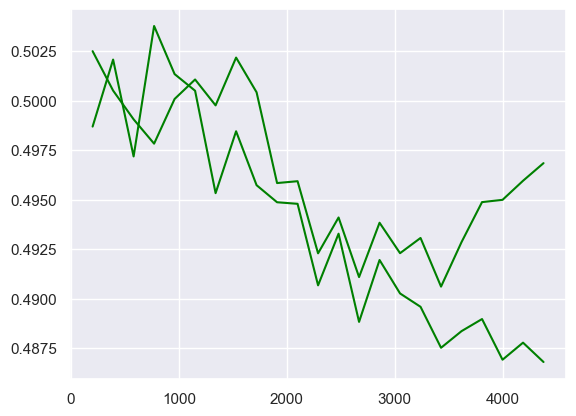

In [214]:
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[0],color="green")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[1],color="green")
plt.savefig('01.png',dpi=300)

C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\2886331199.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[2],color="orange")
C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\2886331199.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[3],color="orange")


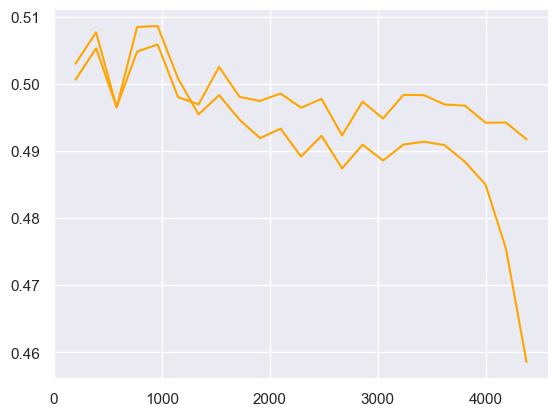

In [213]:
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[2],color="orange")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[3],color="orange")
plt.savefig('23.png',dpi=300)

C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\2447323638.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[4],color="red",label="Block 1")
C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\2447323638.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[5],color="red",label="Block 1")
C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\2447323638.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(

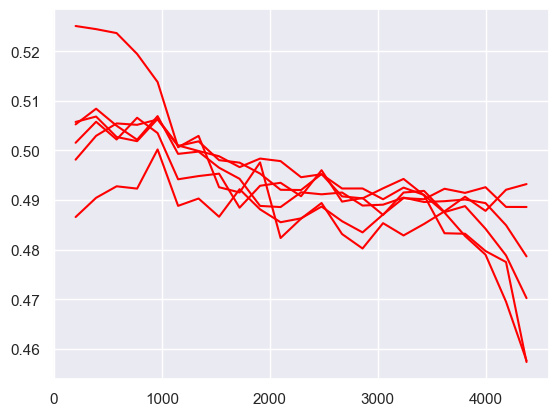

In [212]:
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[4],color="red",label="Block 1")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[5],color="red",label="Block 1")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[6],color="red",label="Block 1")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[7],color="red",label="Block 1")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[8],color="red",label="Block 1")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[9],color="red",label="Block 1")
plt.savefig('49.png',dpi=300)

C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\2661544555.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[10],color="orange",label="Block 1")
C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\2661544555.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[11],color="orange",label="Block 1")
C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\2661544555.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p

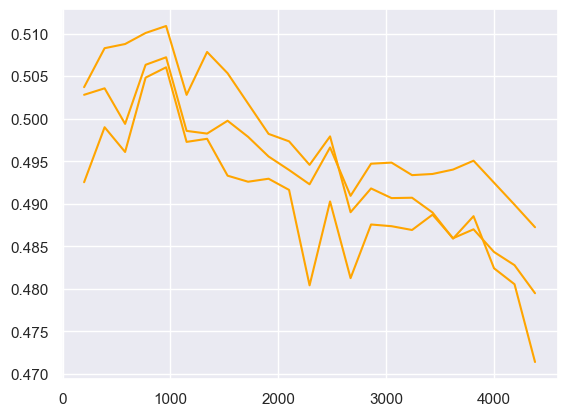

In [211]:
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[10],color="orange",label="Block 1")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[11],color="orange",label="Block 1")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[12],color="orange",label="Block 1")
plt.savefig('1012.png',dpi=300)

C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\1117177483.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[13],color="green",label="Block 1")
C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\1117177483.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[14],color="green",label="Block 1")
C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\1117177483.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt

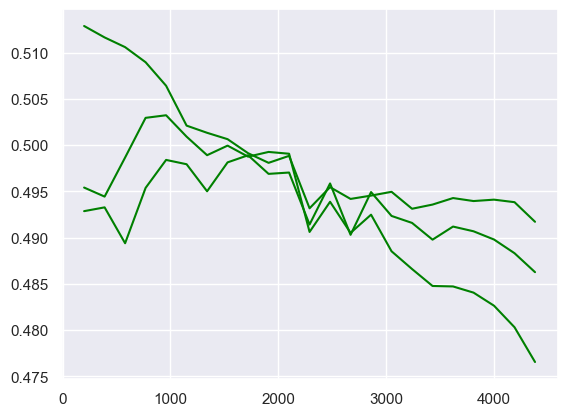

In [210]:
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[13],color="green",label="Block 1")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[14],color="green",label="Block 1")
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu()[15],color="green",label="Block 1")
plt.savefig('1315.png',dpi=300)

C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\890239909.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu().mean(dim=0),color="green")


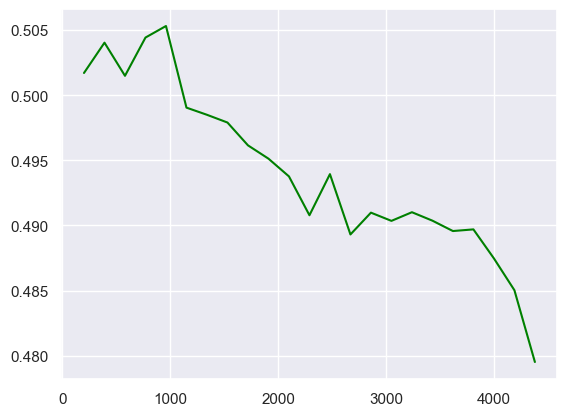

In [216]:
plt.plot(to_save,torch.tensor(prop_total_att_in_mask_all).T.cpu().mean(dim=0),color="green")
plt.savefig('mean_att_in_mask.png',dpi=300)

C:\Users\ilias\AppData\Local\Temp\ipykernel_10940\3846492702.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(range(16),torch.tensor(prop_total_att_in_mask_all).cpu().mean(dim=0),color="green")


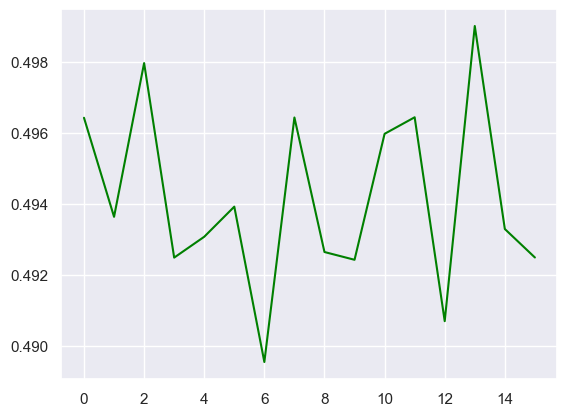

In [221]:
plt.plot(range(16),torch.tensor(prop_total_att_in_mask_all).cpu().mean(dim=0),color="green")
plt.savefig('mean_per_block',dpi=300)

In [170]:
for b in blocks:
    print(b.dim)

[32, 32]
[32, 32]
[16, 16]
[16, 16]
[8, 8]
[8, 8]
[8, 8]
[8, 8]
[8, 8]
[8, 8]
[16, 16]
[16, 16]
[16, 16]
[32, 32]
[32, 32]
[32, 32]


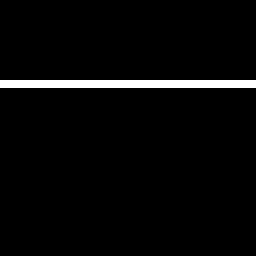

In [28]:
def IMG(img):
    return(torchvision.transforms.ToPILImage()(torchvision.transforms.Resize((256,256),interpolation=torchvision.transforms.InterpolationMode.NEAREST)(img.unsqueeze(0))[0]))

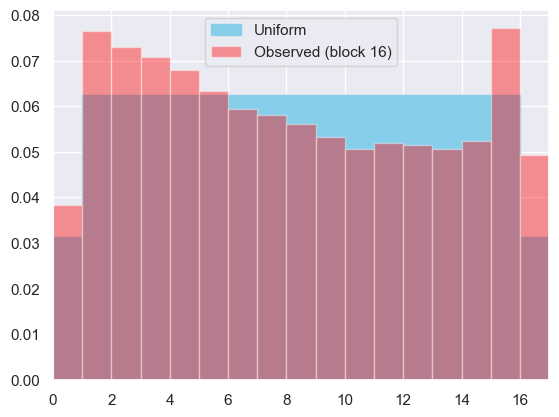

In [308]:
start_point = 0
b = 15
values_b0 = torch.tensor(mo_dist_values_all[start_point][b])

_,bar,_ = plt.hist(dist_to_mask_full.cpu().detach(),bins=range(18), density=True,color = "skyblue", ec="skyblue",label="Uniform")
plt.xlim(0,17)
_ = plt.hist(values_b0.int(),bins=range(18),alpha=0.4,density=True,color="red",label="Observed (block " + str(b+1)+')')

plt.legend()

plt.savefig('32_'+str(b)+'.png',dpi=300)


(array([0.03125, 0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.0625 ,
        0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.0625 ,
        0.0625 , 0.0625 , 0.03125]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17.]),
 <BarContainer object of 17 artists>)

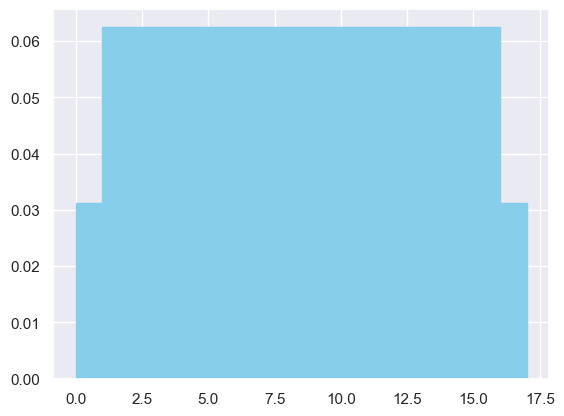

In [238]:
plt.hist(dist_to_mask_full.cpu().detach(),bins=range(18), density=True,color = "skyblue", ec="skyblue")


In [283]:
imgs = []
for start_point in tqdm(range(22)):
    start_point = 22
    b = 0
    mos = torch.tensor(mo_all[start_point][b]).int()
    x, y  = torch.unique(mos,return_counts=True)
    #y = (y.float()/y.max())
    y.shape

    template = torch.zeros(blocks[b].dim).flatten()
    for i in range(len(x)):
        patch = x[i]
        count = y[i]
        template[patch]+=count

    template = template/template.max()
    template = torch.exp(template)

    template = 255*template/template.max()
    template = template.reshape(blocks[b].dim)
    imgs.append(template)
#IMG(template)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:03<00:00,  5.62s/it]


In [286]:
t = torch.stack(imgs).mean(dim=0)
IMG(t).save('momapexp.png')

(array([ 9738.,  7568.,  4922.,  5112.,  5185.,  5148.,  5318.,  5486.,
         5890.,  6299.,  6350.,  6855.,  7117.,  7357.,  7476.,  7396.,
         6902.,  7023.,  6940.,  6554.,  6327.,  6120.,  6024.,  5346.,
         5223.,  5029.,  5064.,  4727.,  4653., 11070.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <BarContainer object of 30 artists>)

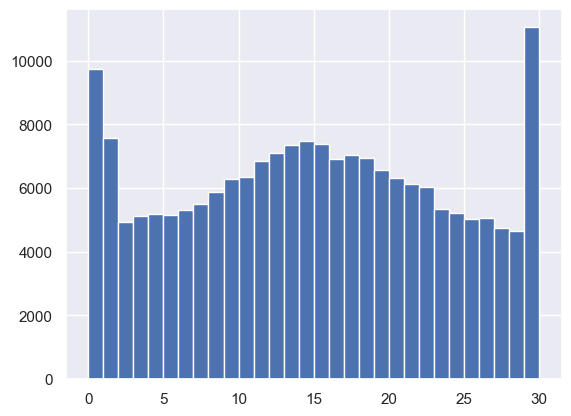

In [91]:
plt.hist(mos%32,bins=range(31))

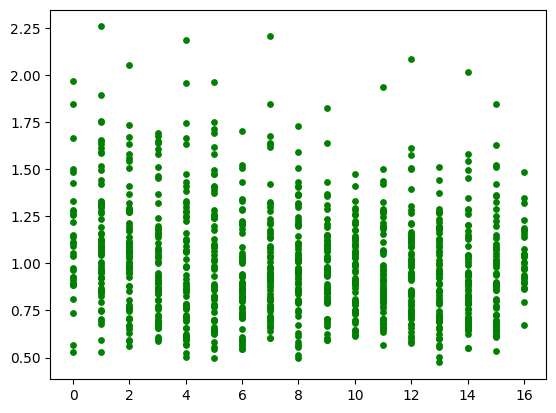

In [69]:
dist_to_mask_full = compute_dist_to_mask(total_attentions.reshape(size,size),mask_border)
plt.scatter(dist_to_mask_full.cpu().detach(),total_attentions.cpu().detach(),s=15,c='green')

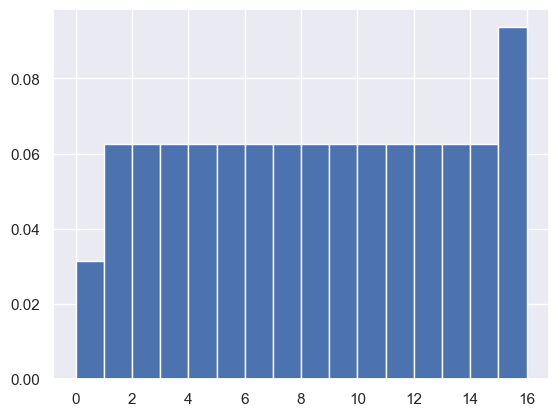

In [103]:
_,bar,_ = plt.hist(dist_to_mask_full.cpu().detach(),bins=16,density=True)